# Notebook 00-isochrones_v2
#### __(Temporal, due to problem on calculate_isochrones() funct)__

Based on what was found on Notebook 00-alameda_isochrones, this notebook helped develop __function analysis.py/proximity_isochrone.__ 
* The function analyses proximity to a point of interest, filters for nodes located at a trip_time or less minutes from the point of interest (count_pois functionality) and returns a convex hull geometry around those nodes.

On this notebook the function is also tested for a greater amount of points of interest. That helped develop __Script 24-nodes_isochrones.py__.

## Import libraries

In [1]:
import os
import sys

import pandas as pd
import geopandas as gpd
import osmnx as ox
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

module_path = os.path.abspath(os.path.join('../../../'))
if module_path not in sys.path:
    sys.path.append(module_path)
    import aup

## Required data - Create a small OSMnx Network for tests

### Required data - Area of interest

<Axes: >

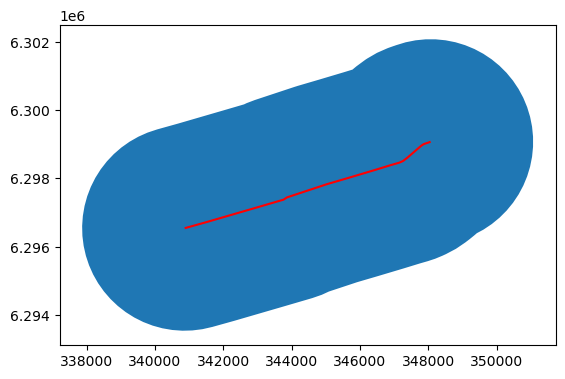

In [2]:
alameda_dir = "../../../data/external/temporal_todocker/santiago/compartido/eje_nueva_alameda_32719.gpkg"
alameda_gdf = gpd.read_file(alameda_dir)
alameda_gdf = alameda_gdf.to_crs("EPSG:4326")

# Create area of interest (aoi)
alameda_projected = alameda_gdf.to_crs("EPSG:32719")
aoi_gdf = alameda_projected.buffer(3000)

# Show plot
fig,ax = plt.subplots()
alameda_projected.plot(ax=ax,zorder=1,color='red')
aoi_gdf.plot(ax=ax,zorder=0)

### Required data - OSMnx Network

In [3]:
# Create Network
G, nodes, edges = aup.create_osmnx_network(aoi_gdf, how='from_polygon', network_type='all_private')

Created OSMnx graph from bounding polygon.
Converted OSMnx graph to 23450 nodes and 59584 edges GeoDataFrame.
Filtered columns.
Column: osmid in nodes gdf, has a list in it, the column data was converted to string.
Column: lanes in nodes gdf, has a list in it, the column data was converted to string.
Column: name in nodes gdf, has a list in it, the column data was converted to string.
Column: highway in nodes gdf, has a list in it, the column data was converted to string.
Column: maxspeed in nodes gdf, has a list in it, the column data was converted to string.
Column: access in nodes gdf, has a list in it, the column data was converted to string.
Column: width in nodes gdf, has a list in it, the column data was converted to string.
Column: service in nodes gdf, has a list in it, the column data was converted to string.


<Axes: >

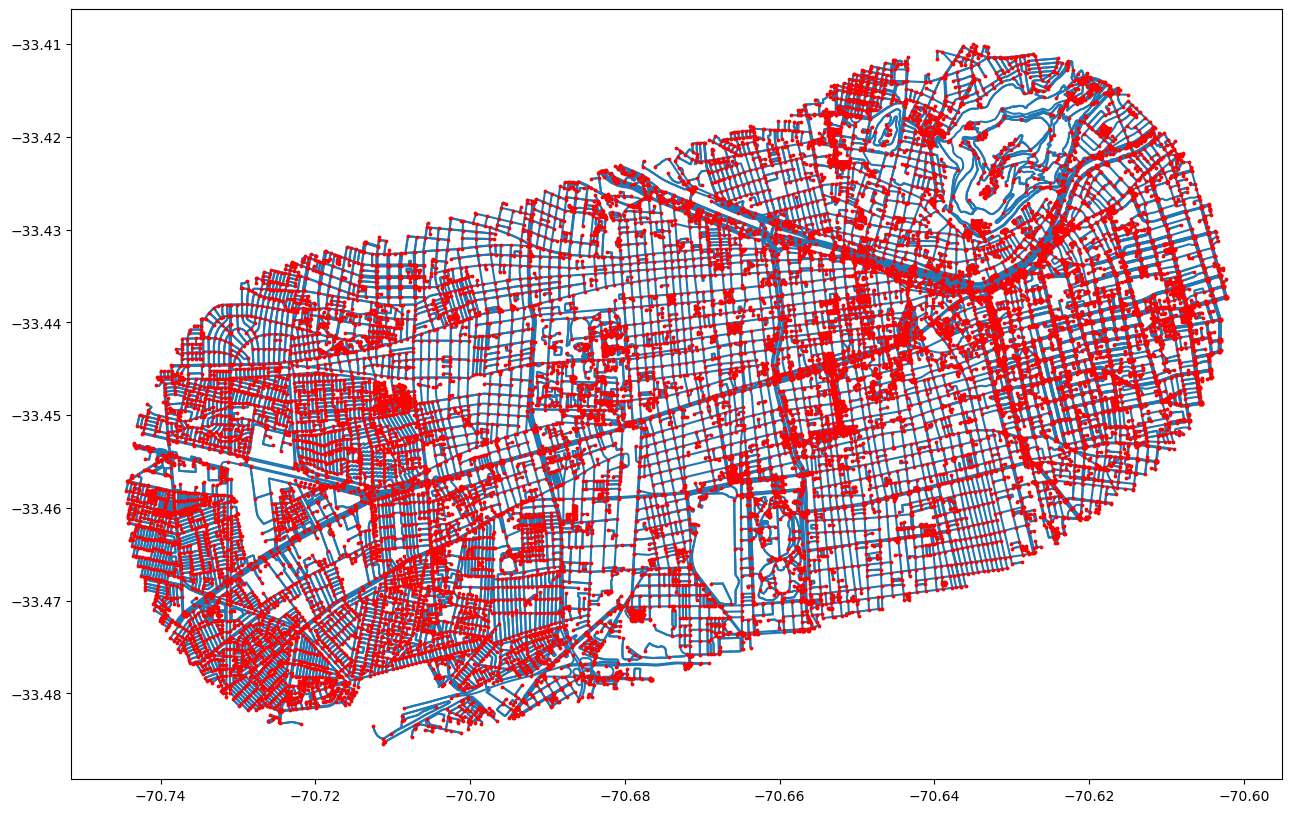

In [4]:
# Show plot
fig,ax = plt.subplots(figsize=(20,10))
nodes.plot(ax=ax,zorder=1,color='red',markersize=3)
edges.plot(ax=ax,zorder=0)

## Dev - Create function that creates isochrones using count_pois from calculate_distance_nearest_poi() function

#### __Attempt 01 - Error__ - Passing all nodes as pois to calculate_distance_nearest_poi creates an interesting map on how many nodes are 15mins or less to each node (Node conectivity)

In [11]:
# Arguments
a=  """ Finds time from each node to nearest poi (point of interest).
	Args:
		G (networkx.MultiDiGraph): Graph with edge bearing attributes
		nodes (geopandas.GeoDataFrame): GeoDataFrame with nodes within boundaries
		edges (geopandas.GeoDataFrame): GeoDataFrame with edges within boundaries
		pois (geopandas.GeoDataFrame): GeoDataFrame with points of interest
		poi_name (str): Text containing name of the point of interest being analysed
		prox_measure (str): Text ("length" or "time_min") used to choose a way to 
							calculate time between nodes and points of interest.
							If "length", will assume a walking speed of 4km/hr.
							If "time_min", edges with time information must be provided.
		count_pois (tuple, optional): tuple containing boolean to find number of pois within given time proximity. Defaults to (False, 0)
		projected_crs (str, optional): string containing projected crs to be used depending on area of interest. Defaults to "EPSG:6372".

	Returns:
		geopandas.GeoDataFrame: GeoDataFrame with nodes containing time to nearest source (s).
	"""
# G=G
# nodes
# edges
# pois won't be needed
poi_name = "nodes"
prox_measure = "length"
count_pois = (True,15)
projected_crs = "EPSG:32719"

##########################################################################################
# STEP 1: NEAREST. 
# Finds and assigns nearest node OSMID to each point of interest.
# (In this case all nodes are pois, so nearest is simulated. The nearest node to each node is itself.)

# pre-format
nodes = nodes.set_crs("EPSG:4326")
edges = edges.set_crs("EPSG:4326")

# Simulate nearest
nearest = nodes.set_crs("EPSG:4326").reset_index()[['osmid','geometry']]

##########################################################################################
# STEP 2: DISTANCE NEAREST POI. 
# Calculates distance from each node to its nearest point of interest using previously assigned nearest node.

# 2.1 --------------- FORMAT NETWORK DATA
# Fill NANs in length with calculated length (prevents crash)
no_length = len(edges.loc[edges['length'].isna()])
edges = edges.to_crs(projected_crs)
edges['length'].fillna(edges.length,inplace=True)
edges = edges.to_crs("EPSG:4326")
print(f"Calculated length for {no_length} edges that had no length data.")

# If prox_measure = 'length', calculates time_min assuming walking speed = 4km/hr
if prox_measure == 'length':
    edges['time_min'] = (edges['length']*60)/4000
else:
    # NaNs in time_min? --> Assume walking speed = 4km/hr
    no_time = len(edges.loc[edges['time_min'].isna()])
    edges['time_min'].fillna((edges['length']*60)/4000,inplace=True)
    print(f"Calculated time for {no_time} edges that had no time data.")

# 2.2 --------------- ELEMENTS NEEDED OUTSIDE THE ANALYSIS LOOP
# The pois are divided by batches of 200 or 250 pois and analysed using the function calculate_distance_nearest_poi.

# nodes_analysis is a nodes gdf (index reseted) used in the function aup.calculate_distance_nearest_poi.
nodes_analysis = nodes.reset_index().copy()
# nodes_time: int_gdf stores, processes time data within the loop and returns final gdf. (df_int, df_temp, df_min and nodes_distance in previous code versions)
nodes_time = nodes.copy()

# --------------- 2.3 PROCESSING DISTANCE
print (f"Starting time analysis for {poi_name}.")

# List of columns with output data by batch
time_cols = []
poiscount_cols = []

# If possible, analyses by batches of 200 pois.
if len(nearest) % 250:
    batch_size = len(nearest)/200
    for k in range(int(batch_size)+1):
        print(f"Starting range k = {k+1} of {int(batch_size)+1} for {poi_name}.")
        # Calculate
        source_process = nearest.iloc[int(200*k):int(200*(1+k))].copy()
        nodes_distance_prep = aup.calculate_distance_nearest_poi(source_process, nodes_analysis, edges, poi_name, 'osmid', wght='time_min',count_pois=count_pois)

        # Extract from nodes_distance_prep the calculated time data
        batch_time_col = 'time_'+str(k)+poi_name
        time_cols.append(batch_time_col)
        nodes_time[batch_time_col] = nodes_distance_prep['dist_'+poi_name]

        # If requested, extract from nodes_distance_prep the calculated pois count
        if count_pois[0]:
            batch_poiscount_col = f'{poi_name}_{str(k)}_{count_pois[1]}min'
            poiscount_cols.append(batch_poiscount_col)
            nodes_time[batch_poiscount_col] = nodes_distance_prep[f'{poi_name}_{count_pois[1]}min']

    # After batch processing is over, find final output values for all batches.
    # For time data, apply the min function to time columns.
    nodes_time['time_'+poi_name] = nodes_time[time_cols].min(axis=1)
    # If requested, apply the sum function to pois_count columns. 
    if count_pois[0]:
        # Sum pois count
        nodes_time[f'{poi_name}_{count_pois[1]}min'] = nodes_time[poiscount_cols].sum(axis=1)

# Else, analyses by batches of 250 pois.
else:
    batch_size = len(nearest)/250
    for k in range(int(batch_size)+1):
        print(f"Starting range k = {k+1} of {int(batch_size)+1} for source {poi_name}.")
        # Calculate
        source_process = nearest.iloc[int(250*k):int(250*(1+k))].copy()
        nodes_distance_prep = aup.calculate_distance_nearest_poi(source_process, nodes_analysis, edges, poi_name, 'osmid', wght='time_min',count_pois=count_pois)

        # Extract from nodes_distance_prep the calculated time data
        batch_time_col = 'time_'+str(k)+poi_name
        time_cols.append(batch_time_col)
        nodes_time[batch_time_col] = nodes_distance_prep['dist_'+poi_name]

        # If requested, extract from nodes_distance_prep the calculated pois count
        if count_pois[0]:
            batch_poiscount_col = f'{poi_name}_{str(k)}_{count_pois[1]}min'
            poiscount_cols.append(batch_poiscount_col)
            nodes_time[batch_poiscount_col] = nodes_distance_prep[f'{poi_name}_{count_pois[1]}min']

    # After batch processing is over, find final output values for all batches.
    # For time data, apply the min function to time columns.
    nodes_time['time_'+poi_name] = nodes_time[time_cols].min(axis=1)
    # If requested, apply the sum function to pois_count columns. 
    if count_pois[0]:
        # Sum pois count
        nodes_time[f'{poi_name}_{count_pois[1]}min'] = nodes_time[poiscount_cols].sum(axis=1)

print(f"Finished time analysis for {poi_name}.")

##########################################################################################
# Step 3: FINAL FORMAT. 
# Organices and filters output data.

nodes_time.reset_index(inplace=True)
nodes_time = nodes_time.set_crs("EPSG:4326")

if count_pois[0]:
    nodes_time = nodes_time[['osmid','time_'+poi_name,f'{poi_name}_{count_pois[1]}min','x','y','geometry']]
else:
    nodes_time = nodes_time[['osmid','time_'+poi_name,'x','y','geometry']]

nodes_time

Calculated length for 0 edges that had no length data.
Starting time analysis for nodes.
Starting range k = 1 of 118 for nodes.
Starting range k = 2 of 118 for nodes.
Starting range k = 3 of 118 for nodes.
Starting range k = 4 of 118 for nodes.
Starting range k = 5 of 118 for nodes.
Starting range k = 6 of 118 for nodes.
Starting range k = 7 of 118 for nodes.
Starting range k = 8 of 118 for nodes.
Starting range k = 9 of 118 for nodes.
Starting range k = 10 of 118 for nodes.
Starting range k = 11 of 118 for nodes.
Starting range k = 12 of 118 for nodes.
Starting range k = 13 of 118 for nodes.
Starting range k = 14 of 118 for nodes.
Starting range k = 15 of 118 for nodes.
Starting range k = 16 of 118 for nodes.
Starting range k = 17 of 118 for nodes.
Starting range k = 18 of 118 for nodes.
Starting range k = 19 of 118 for nodes.
Starting range k = 20 of 118 for nodes.
Starting range k = 21 of 118 for nodes.
Starting range k = 22 of 118 for nodes.
Starting range k = 23 of 118 for nodes.


/opt/conda/envs/gds/lib/python3.9/site-packages/geopandas/geodataframe.py:1525: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  super().__setitem__(key, value)
/opt/conda/envs/gds/lib/python3.9/site-packages/geopandas/geodataframe.py:1525: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  super().__setitem__(key, value)


Starting range k = 51 of 118 for nodes.


/opt/conda/envs/gds/lib/python3.9/site-packages/geopandas/geodataframe.py:1525: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  super().__setitem__(key, value)
/opt/conda/envs/gds/lib/python3.9/site-packages/geopandas/geodataframe.py:1525: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  super().__setitem__(key, value)


Starting range k = 52 of 118 for nodes.


/opt/conda/envs/gds/lib/python3.9/site-packages/geopandas/geodataframe.py:1525: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  super().__setitem__(key, value)
/opt/conda/envs/gds/lib/python3.9/site-packages/geopandas/geodataframe.py:1525: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  super().__setitem__(key, value)


Starting range k = 53 of 118 for nodes.


/opt/conda/envs/gds/lib/python3.9/site-packages/geopandas/geodataframe.py:1525: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  super().__setitem__(key, value)
/opt/conda/envs/gds/lib/python3.9/site-packages/geopandas/geodataframe.py:1525: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  super().__setitem__(key, value)


Starting range k = 54 of 118 for nodes.


/opt/conda/envs/gds/lib/python3.9/site-packages/geopandas/geodataframe.py:1525: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  super().__setitem__(key, value)
/opt/conda/envs/gds/lib/python3.9/site-packages/geopandas/geodataframe.py:1525: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  super().__setitem__(key, value)


Starting range k = 55 of 118 for nodes.


/opt/conda/envs/gds/lib/python3.9/site-packages/geopandas/geodataframe.py:1525: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  super().__setitem__(key, value)
/opt/conda/envs/gds/lib/python3.9/site-packages/geopandas/geodataframe.py:1525: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  super().__setitem__(key, value)


Starting range k = 56 of 118 for nodes.


/opt/conda/envs/gds/lib/python3.9/site-packages/geopandas/geodataframe.py:1525: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  super().__setitem__(key, value)
/opt/conda/envs/gds/lib/python3.9/site-packages/geopandas/geodataframe.py:1525: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  super().__setitem__(key, value)


Starting range k = 57 of 118 for nodes.


/opt/conda/envs/gds/lib/python3.9/site-packages/geopandas/geodataframe.py:1525: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  super().__setitem__(key, value)
/opt/conda/envs/gds/lib/python3.9/site-packages/geopandas/geodataframe.py:1525: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  super().__setitem__(key, value)


Starting range k = 58 of 118 for nodes.


/opt/conda/envs/gds/lib/python3.9/site-packages/geopandas/geodataframe.py:1525: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  super().__setitem__(key, value)
/opt/conda/envs/gds/lib/python3.9/site-packages/geopandas/geodataframe.py:1525: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  super().__setitem__(key, value)


Starting range k = 59 of 118 for nodes.


/opt/conda/envs/gds/lib/python3.9/site-packages/geopandas/geodataframe.py:1525: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  super().__setitem__(key, value)
/opt/conda/envs/gds/lib/python3.9/site-packages/geopandas/geodataframe.py:1525: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  super().__setitem__(key, value)


Starting range k = 60 of 118 for nodes.


/opt/conda/envs/gds/lib/python3.9/site-packages/geopandas/geodataframe.py:1525: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  super().__setitem__(key, value)
/opt/conda/envs/gds/lib/python3.9/site-packages/geopandas/geodataframe.py:1525: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  super().__setitem__(key, value)


Starting range k = 61 of 118 for nodes.


/opt/conda/envs/gds/lib/python3.9/site-packages/geopandas/geodataframe.py:1525: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  super().__setitem__(key, value)
/opt/conda/envs/gds/lib/python3.9/site-packages/geopandas/geodataframe.py:1525: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  super().__setitem__(key, value)


Starting range k = 62 of 118 for nodes.


/opt/conda/envs/gds/lib/python3.9/site-packages/geopandas/geodataframe.py:1525: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  super().__setitem__(key, value)
/opt/conda/envs/gds/lib/python3.9/site-packages/geopandas/geodataframe.py:1525: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  super().__setitem__(key, value)


Starting range k = 63 of 118 for nodes.


/opt/conda/envs/gds/lib/python3.9/site-packages/geopandas/geodataframe.py:1525: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  super().__setitem__(key, value)
/opt/conda/envs/gds/lib/python3.9/site-packages/geopandas/geodataframe.py:1525: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  super().__setitem__(key, value)


Starting range k = 64 of 118 for nodes.


/opt/conda/envs/gds/lib/python3.9/site-packages/geopandas/geodataframe.py:1525: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  super().__setitem__(key, value)
/opt/conda/envs/gds/lib/python3.9/site-packages/geopandas/geodataframe.py:1525: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  super().__setitem__(key, value)


Starting range k = 65 of 118 for nodes.


/opt/conda/envs/gds/lib/python3.9/site-packages/geopandas/geodataframe.py:1525: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  super().__setitem__(key, value)
/opt/conda/envs/gds/lib/python3.9/site-packages/geopandas/geodataframe.py:1525: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  super().__setitem__(key, value)


Starting range k = 66 of 118 for nodes.


/opt/conda/envs/gds/lib/python3.9/site-packages/geopandas/geodataframe.py:1525: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  super().__setitem__(key, value)
/opt/conda/envs/gds/lib/python3.9/site-packages/geopandas/geodataframe.py:1525: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  super().__setitem__(key, value)


Starting range k = 67 of 118 for nodes.


/opt/conda/envs/gds/lib/python3.9/site-packages/geopandas/geodataframe.py:1525: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  super().__setitem__(key, value)
/opt/conda/envs/gds/lib/python3.9/site-packages/geopandas/geodataframe.py:1525: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  super().__setitem__(key, value)


Starting range k = 68 of 118 for nodes.


/opt/conda/envs/gds/lib/python3.9/site-packages/geopandas/geodataframe.py:1525: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  super().__setitem__(key, value)
/opt/conda/envs/gds/lib/python3.9/site-packages/geopandas/geodataframe.py:1525: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  super().__setitem__(key, value)


Starting range k = 69 of 118 for nodes.


/opt/conda/envs/gds/lib/python3.9/site-packages/geopandas/geodataframe.py:1525: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  super().__setitem__(key, value)
/opt/conda/envs/gds/lib/python3.9/site-packages/geopandas/geodataframe.py:1525: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  super().__setitem__(key, value)


Starting range k = 70 of 118 for nodes.


/opt/conda/envs/gds/lib/python3.9/site-packages/geopandas/geodataframe.py:1525: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  super().__setitem__(key, value)
/opt/conda/envs/gds/lib/python3.9/site-packages/geopandas/geodataframe.py:1525: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  super().__setitem__(key, value)


Starting range k = 71 of 118 for nodes.


/opt/conda/envs/gds/lib/python3.9/site-packages/geopandas/geodataframe.py:1525: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  super().__setitem__(key, value)
/opt/conda/envs/gds/lib/python3.9/site-packages/geopandas/geodataframe.py:1525: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  super().__setitem__(key, value)


Starting range k = 72 of 118 for nodes.


/opt/conda/envs/gds/lib/python3.9/site-packages/geopandas/geodataframe.py:1525: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  super().__setitem__(key, value)
/opt/conda/envs/gds/lib/python3.9/site-packages/geopandas/geodataframe.py:1525: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  super().__setitem__(key, value)


Starting range k = 73 of 118 for nodes.


/opt/conda/envs/gds/lib/python3.9/site-packages/geopandas/geodataframe.py:1525: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  super().__setitem__(key, value)
/opt/conda/envs/gds/lib/python3.9/site-packages/geopandas/geodataframe.py:1525: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  super().__setitem__(key, value)


Starting range k = 74 of 118 for nodes.


/opt/conda/envs/gds/lib/python3.9/site-packages/geopandas/geodataframe.py:1525: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  super().__setitem__(key, value)
/opt/conda/envs/gds/lib/python3.9/site-packages/geopandas/geodataframe.py:1525: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  super().__setitem__(key, value)


Starting range k = 75 of 118 for nodes.


/opt/conda/envs/gds/lib/python3.9/site-packages/geopandas/geodataframe.py:1525: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  super().__setitem__(key, value)
/opt/conda/envs/gds/lib/python3.9/site-packages/geopandas/geodataframe.py:1525: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  super().__setitem__(key, value)


Starting range k = 76 of 118 for nodes.


/opt/conda/envs/gds/lib/python3.9/site-packages/geopandas/geodataframe.py:1525: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  super().__setitem__(key, value)
/opt/conda/envs/gds/lib/python3.9/site-packages/geopandas/geodataframe.py:1525: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  super().__setitem__(key, value)


Starting range k = 77 of 118 for nodes.


/opt/conda/envs/gds/lib/python3.9/site-packages/geopandas/geodataframe.py:1525: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  super().__setitem__(key, value)
/opt/conda/envs/gds/lib/python3.9/site-packages/geopandas/geodataframe.py:1525: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  super().__setitem__(key, value)


Starting range k = 78 of 118 for nodes.


/opt/conda/envs/gds/lib/python3.9/site-packages/geopandas/geodataframe.py:1525: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  super().__setitem__(key, value)
/opt/conda/envs/gds/lib/python3.9/site-packages/geopandas/geodataframe.py:1525: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  super().__setitem__(key, value)


Starting range k = 79 of 118 for nodes.


/opt/conda/envs/gds/lib/python3.9/site-packages/geopandas/geodataframe.py:1525: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  super().__setitem__(key, value)
/opt/conda/envs/gds/lib/python3.9/site-packages/geopandas/geodataframe.py:1525: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  super().__setitem__(key, value)


Starting range k = 80 of 118 for nodes.


/opt/conda/envs/gds/lib/python3.9/site-packages/geopandas/geodataframe.py:1525: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  super().__setitem__(key, value)
/opt/conda/envs/gds/lib/python3.9/site-packages/geopandas/geodataframe.py:1525: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  super().__setitem__(key, value)


Starting range k = 81 of 118 for nodes.


/opt/conda/envs/gds/lib/python3.9/site-packages/geopandas/geodataframe.py:1525: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  super().__setitem__(key, value)
/opt/conda/envs/gds/lib/python3.9/site-packages/geopandas/geodataframe.py:1525: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  super().__setitem__(key, value)


Starting range k = 82 of 118 for nodes.


/opt/conda/envs/gds/lib/python3.9/site-packages/geopandas/geodataframe.py:1525: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  super().__setitem__(key, value)
/opt/conda/envs/gds/lib/python3.9/site-packages/geopandas/geodataframe.py:1525: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  super().__setitem__(key, value)


Starting range k = 83 of 118 for nodes.


/opt/conda/envs/gds/lib/python3.9/site-packages/geopandas/geodataframe.py:1525: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  super().__setitem__(key, value)
/opt/conda/envs/gds/lib/python3.9/site-packages/geopandas/geodataframe.py:1525: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  super().__setitem__(key, value)


Starting range k = 84 of 118 for nodes.


/opt/conda/envs/gds/lib/python3.9/site-packages/geopandas/geodataframe.py:1525: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  super().__setitem__(key, value)
/opt/conda/envs/gds/lib/python3.9/site-packages/geopandas/geodataframe.py:1525: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  super().__setitem__(key, value)


Starting range k = 85 of 118 for nodes.


/opt/conda/envs/gds/lib/python3.9/site-packages/geopandas/geodataframe.py:1525: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  super().__setitem__(key, value)
/opt/conda/envs/gds/lib/python3.9/site-packages/geopandas/geodataframe.py:1525: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  super().__setitem__(key, value)


Starting range k = 86 of 118 for nodes.


/opt/conda/envs/gds/lib/python3.9/site-packages/geopandas/geodataframe.py:1525: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  super().__setitem__(key, value)
/opt/conda/envs/gds/lib/python3.9/site-packages/geopandas/geodataframe.py:1525: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  super().__setitem__(key, value)


Starting range k = 87 of 118 for nodes.


/opt/conda/envs/gds/lib/python3.9/site-packages/geopandas/geodataframe.py:1525: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  super().__setitem__(key, value)
/opt/conda/envs/gds/lib/python3.9/site-packages/geopandas/geodataframe.py:1525: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  super().__setitem__(key, value)


Starting range k = 88 of 118 for nodes.


/opt/conda/envs/gds/lib/python3.9/site-packages/geopandas/geodataframe.py:1525: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  super().__setitem__(key, value)
/opt/conda/envs/gds/lib/python3.9/site-packages/geopandas/geodataframe.py:1525: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  super().__setitem__(key, value)


Starting range k = 89 of 118 for nodes.


/opt/conda/envs/gds/lib/python3.9/site-packages/geopandas/geodataframe.py:1525: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  super().__setitem__(key, value)
/opt/conda/envs/gds/lib/python3.9/site-packages/geopandas/geodataframe.py:1525: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  super().__setitem__(key, value)


Starting range k = 90 of 118 for nodes.


/opt/conda/envs/gds/lib/python3.9/site-packages/geopandas/geodataframe.py:1525: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  super().__setitem__(key, value)
/opt/conda/envs/gds/lib/python3.9/site-packages/geopandas/geodataframe.py:1525: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  super().__setitem__(key, value)


Starting range k = 91 of 118 for nodes.


/opt/conda/envs/gds/lib/python3.9/site-packages/geopandas/geodataframe.py:1525: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  super().__setitem__(key, value)
/opt/conda/envs/gds/lib/python3.9/site-packages/geopandas/geodataframe.py:1525: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  super().__setitem__(key, value)


Starting range k = 92 of 118 for nodes.


/opt/conda/envs/gds/lib/python3.9/site-packages/geopandas/geodataframe.py:1525: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  super().__setitem__(key, value)
/opt/conda/envs/gds/lib/python3.9/site-packages/geopandas/geodataframe.py:1525: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  super().__setitem__(key, value)


Starting range k = 93 of 118 for nodes.


/opt/conda/envs/gds/lib/python3.9/site-packages/geopandas/geodataframe.py:1525: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  super().__setitem__(key, value)
/opt/conda/envs/gds/lib/python3.9/site-packages/geopandas/geodataframe.py:1525: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  super().__setitem__(key, value)


Starting range k = 94 of 118 for nodes.


/opt/conda/envs/gds/lib/python3.9/site-packages/geopandas/geodataframe.py:1525: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  super().__setitem__(key, value)
/opt/conda/envs/gds/lib/python3.9/site-packages/geopandas/geodataframe.py:1525: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  super().__setitem__(key, value)


Starting range k = 95 of 118 for nodes.


/opt/conda/envs/gds/lib/python3.9/site-packages/geopandas/geodataframe.py:1525: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  super().__setitem__(key, value)
/opt/conda/envs/gds/lib/python3.9/site-packages/geopandas/geodataframe.py:1525: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  super().__setitem__(key, value)


Starting range k = 96 of 118 for nodes.


/opt/conda/envs/gds/lib/python3.9/site-packages/geopandas/geodataframe.py:1525: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  super().__setitem__(key, value)
/opt/conda/envs/gds/lib/python3.9/site-packages/geopandas/geodataframe.py:1525: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  super().__setitem__(key, value)


Starting range k = 97 of 118 for nodes.


/opt/conda/envs/gds/lib/python3.9/site-packages/geopandas/geodataframe.py:1525: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  super().__setitem__(key, value)
/opt/conda/envs/gds/lib/python3.9/site-packages/geopandas/geodataframe.py:1525: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  super().__setitem__(key, value)


Starting range k = 98 of 118 for nodes.


/opt/conda/envs/gds/lib/python3.9/site-packages/geopandas/geodataframe.py:1525: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  super().__setitem__(key, value)
/opt/conda/envs/gds/lib/python3.9/site-packages/geopandas/geodataframe.py:1525: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  super().__setitem__(key, value)


Starting range k = 99 of 118 for nodes.


/opt/conda/envs/gds/lib/python3.9/site-packages/geopandas/geodataframe.py:1525: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  super().__setitem__(key, value)
/opt/conda/envs/gds/lib/python3.9/site-packages/geopandas/geodataframe.py:1525: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  super().__setitem__(key, value)


Starting range k = 100 of 118 for nodes.


/opt/conda/envs/gds/lib/python3.9/site-packages/geopandas/geodataframe.py:1525: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  super().__setitem__(key, value)
/opt/conda/envs/gds/lib/python3.9/site-packages/geopandas/geodataframe.py:1525: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  super().__setitem__(key, value)


Starting range k = 101 of 118 for nodes.


/opt/conda/envs/gds/lib/python3.9/site-packages/geopandas/geodataframe.py:1525: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  super().__setitem__(key, value)
/opt/conda/envs/gds/lib/python3.9/site-packages/geopandas/geodataframe.py:1525: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  super().__setitem__(key, value)


Starting range k = 102 of 118 for nodes.


/opt/conda/envs/gds/lib/python3.9/site-packages/geopandas/geodataframe.py:1525: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  super().__setitem__(key, value)
/opt/conda/envs/gds/lib/python3.9/site-packages/geopandas/geodataframe.py:1525: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  super().__setitem__(key, value)


Starting range k = 103 of 118 for nodes.


/opt/conda/envs/gds/lib/python3.9/site-packages/geopandas/geodataframe.py:1525: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  super().__setitem__(key, value)
/opt/conda/envs/gds/lib/python3.9/site-packages/geopandas/geodataframe.py:1525: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  super().__setitem__(key, value)


Starting range k = 104 of 118 for nodes.


/opt/conda/envs/gds/lib/python3.9/site-packages/geopandas/geodataframe.py:1525: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  super().__setitem__(key, value)
/opt/conda/envs/gds/lib/python3.9/site-packages/geopandas/geodataframe.py:1525: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  super().__setitem__(key, value)


Starting range k = 105 of 118 for nodes.


/opt/conda/envs/gds/lib/python3.9/site-packages/geopandas/geodataframe.py:1525: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  super().__setitem__(key, value)
/opt/conda/envs/gds/lib/python3.9/site-packages/geopandas/geodataframe.py:1525: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  super().__setitem__(key, value)


Starting range k = 106 of 118 for nodes.


/opt/conda/envs/gds/lib/python3.9/site-packages/geopandas/geodataframe.py:1525: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  super().__setitem__(key, value)
/opt/conda/envs/gds/lib/python3.9/site-packages/geopandas/geodataframe.py:1525: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  super().__setitem__(key, value)


Starting range k = 107 of 118 for nodes.


/opt/conda/envs/gds/lib/python3.9/site-packages/geopandas/geodataframe.py:1525: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  super().__setitem__(key, value)
/opt/conda/envs/gds/lib/python3.9/site-packages/geopandas/geodataframe.py:1525: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  super().__setitem__(key, value)


Starting range k = 108 of 118 for nodes.


/opt/conda/envs/gds/lib/python3.9/site-packages/geopandas/geodataframe.py:1525: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  super().__setitem__(key, value)
/opt/conda/envs/gds/lib/python3.9/site-packages/geopandas/geodataframe.py:1525: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  super().__setitem__(key, value)


Starting range k = 109 of 118 for nodes.


/opt/conda/envs/gds/lib/python3.9/site-packages/geopandas/geodataframe.py:1525: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  super().__setitem__(key, value)
/opt/conda/envs/gds/lib/python3.9/site-packages/geopandas/geodataframe.py:1525: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  super().__setitem__(key, value)


Starting range k = 110 of 118 for nodes.


/opt/conda/envs/gds/lib/python3.9/site-packages/geopandas/geodataframe.py:1525: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  super().__setitem__(key, value)
/opt/conda/envs/gds/lib/python3.9/site-packages/geopandas/geodataframe.py:1525: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  super().__setitem__(key, value)


Starting range k = 111 of 118 for nodes.


/opt/conda/envs/gds/lib/python3.9/site-packages/geopandas/geodataframe.py:1525: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  super().__setitem__(key, value)
/opt/conda/envs/gds/lib/python3.9/site-packages/geopandas/geodataframe.py:1525: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  super().__setitem__(key, value)


Starting range k = 112 of 118 for nodes.


/opt/conda/envs/gds/lib/python3.9/site-packages/geopandas/geodataframe.py:1525: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  super().__setitem__(key, value)
/opt/conda/envs/gds/lib/python3.9/site-packages/geopandas/geodataframe.py:1525: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  super().__setitem__(key, value)


Starting range k = 113 of 118 for nodes.


/opt/conda/envs/gds/lib/python3.9/site-packages/geopandas/geodataframe.py:1525: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  super().__setitem__(key, value)
/opt/conda/envs/gds/lib/python3.9/site-packages/geopandas/geodataframe.py:1525: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  super().__setitem__(key, value)


Starting range k = 114 of 118 for nodes.


/opt/conda/envs/gds/lib/python3.9/site-packages/geopandas/geodataframe.py:1525: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  super().__setitem__(key, value)
/opt/conda/envs/gds/lib/python3.9/site-packages/geopandas/geodataframe.py:1525: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  super().__setitem__(key, value)


Starting range k = 115 of 118 for nodes.


/opt/conda/envs/gds/lib/python3.9/site-packages/geopandas/geodataframe.py:1525: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  super().__setitem__(key, value)
/opt/conda/envs/gds/lib/python3.9/site-packages/geopandas/geodataframe.py:1525: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  super().__setitem__(key, value)


Starting range k = 116 of 118 for nodes.


/opt/conda/envs/gds/lib/python3.9/site-packages/geopandas/geodataframe.py:1525: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  super().__setitem__(key, value)
/opt/conda/envs/gds/lib/python3.9/site-packages/geopandas/geodataframe.py:1525: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  super().__setitem__(key, value)


Starting range k = 117 of 118 for nodes.


/opt/conda/envs/gds/lib/python3.9/site-packages/geopandas/geodataframe.py:1525: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  super().__setitem__(key, value)
/opt/conda/envs/gds/lib/python3.9/site-packages/geopandas/geodataframe.py:1525: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  super().__setitem__(key, value)


Starting range k = 118 of 118 for nodes.
Finished time analysis for nodes.


/opt/conda/envs/gds/lib/python3.9/site-packages/geopandas/geodataframe.py:1525: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  super().__setitem__(key, value)
/opt/conda/envs/gds/lib/python3.9/site-packages/geopandas/geodataframe.py:1525: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  super().__setitem__(key, value)
/opt/conda/envs/gds/lib/python3.9/site-packages/geopandas/geodataframe.py:1525: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor perfo

,osmid,time_nodes,nodes_15min,x,y,geometry
0,386138,0.0,1110,-70.646254,-33.442901,POINT (-70.64625 -33.44290)
1,386139,0.0,1152,-70.647249,-33.443129,POINT (-70.64725 -33.44313)
2,386140,0.0,1156,-70.647670,-33.443035,POINT (-70.64767 -33.44304)
3,386145,0.0,1195,-70.648970,-33.443343,POINT (-70.64897 -33.44334)
4,386147,0.0,1195,-70.650375,-33.443669,POINT (-70.65038 -33.44367)
...,...,...,...,...,...,...
23445,11889994086,0.0,261,-70.735764,-33.455514,POINT (-70.73576 -33.45551)
23446,11889994088,0.0,312,-70.735724,-33.454989,POINT (-70.73572 -33.45499)
23447,11890070111,0.0,550,-70.630833,-33.455287,POINT (-70.63083 -33.45529)
23448,11890070112,0.0,609,-70.631388,-33.455392,POINT (-70.63139 -33.45539)


<Axes: >

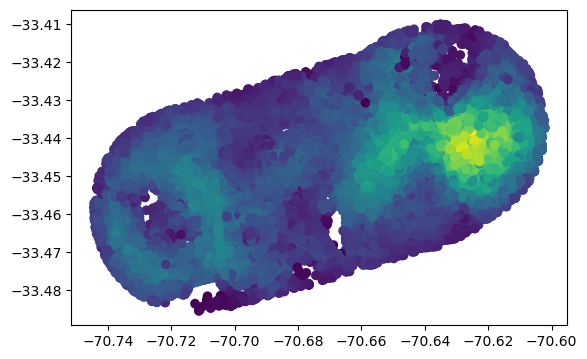

In [13]:
nodes_time.plot('nodes_15min')

#### __Attempt 02 - Success (one node)__ - Iterating over simulated nearest does the job.

In [28]:
# Arguments
a=  """ Finds time from each node to nearest poi (point of interest).
	Args:
		G (networkx.MultiDiGraph): Graph with edge bearing attributes
		nodes (geopandas.GeoDataFrame): GeoDataFrame with nodes within boundaries
		edges (geopandas.GeoDataFrame): GeoDataFrame with edges within boundaries
		pois (geopandas.GeoDataFrame): GeoDataFrame with points of interest
		poi_name (str): Text containing name of the point of interest being analysed
		prox_measure (str): Text ("length" or "time_min") used to choose a way to 
							calculate time between nodes and points of interest.
							If "length", will assume a walking speed of 4km/hr.
							If "time_min", edges with time information must be provided.
		count_pois (tuple, optional): tuple containing boolean to find number of pois within given time proximity. Defaults to (False, 0)
		projected_crs (str, optional): string containing projected crs to be used depending on area of interest. Defaults to "EPSG:6372".

	Returns:
		geopandas.GeoDataFrame: GeoDataFrame with nodes containing time to nearest source (s).
	"""
# G=G
# nodes
# edges
# pois won't be needed
poi_name = "nodes"
prox_measure = "length"
count_pois = (True,15)
projected_crs = "EPSG:32719"

##########################################################################################
# STEP 1: NEAREST. 
# Finds and assigns nearest node OSMID to each point of interest.
# (In this case all nodes are pois, so nearest is simulated. The nearest node to each node is itself.)

# pre-format
nodes = nodes.set_crs("EPSG:4326")
edges = edges.set_crs("EPSG:4326")

# Simulate nearest
nearest_all = nodes.set_crs("EPSG:4326").reset_index()[['osmid','geometry']]

##########################################################################################
# STEP 2: DISTANCE NEAREST POI. 
# Calculates distance from each node to its nearest point of interest using previously assigned nearest node.

# 2.1 --------------- FORMAT NETWORK DATA
# Fill NANs in length with calculated length (prevents crash)
no_length = len(edges.loc[edges['length'].isna()])
edges = edges.to_crs(projected_crs)
edges['length'].fillna(edges.length,inplace=True)
edges = edges.to_crs("EPSG:4326")
print(f"Calculated length for {no_length} edges that had no length data.")

# If prox_measure = 'length', calculates time_min assuming walking speed = 4km/hr
if prox_measure == 'length':
    edges['time_min'] = (edges['length']*60)/4000
else:
    # NaNs in time_min? --> Assume walking speed = 4km/hr
    no_time = len(edges.loc[edges['time_min'].isna()])
    edges['time_min'].fillna((edges['length']*60)/4000,inplace=True)
    print(f"Calculated time for {no_time} edges that had no time data.")


######################################################### TEST
isochrones_gdf = gpd.GeoDataFrame()
i = 0
#for osmid in list(nearest_all.osmid.unique()): --------------------------> How it would be
#    nearest = nearest_all.loc[nearest_all.osmid == osmid] ---------------> How it would be

nearest = nearest_all.loc[nearest_all.osmid==11889994086] # --------------> Testing one poi_node

######################################################### TEST
    
# 2.2 --------------- ELEMENTS NEEDED OUTSIDE THE ANALYSIS LOOP
# The pois are divided by batches of 200 or 250 pois and analysed using the function calculate_distance_nearest_poi.

# nodes_analysis is a nodes gdf (index reseted) used in the function aup.calculate_distance_nearest_poi.
nodes_analysis = nodes.reset_index().copy()
# nodes_time: int_gdf stores, processes time data within the loop and returns final gdf. (df_int, df_temp, df_min and nodes_distance in previous code versions)
nodes_time = nodes.copy()

# --------------- 2.3 PROCESSING DISTANCE
print (f"Starting time analysis for {poi_name}.")

# List of columns with output data by batch
time_cols = []
poiscount_cols = []

# If possible, analyses by batches of 200 pois.
if len(nearest) % 250:
    batch_size = len(nearest)/200
    for k in range(int(batch_size)+1):
        print(f"Starting range k = {k+1} of {int(batch_size)+1} for {poi_name}.")
        # Calculate
        source_process = nearest.iloc[int(200*k):int(200*(1+k))].copy()
        nodes_distance_prep = aup.calculate_distance_nearest_poi(source_process, nodes_analysis, edges, poi_name, 'osmid', wght='time_min',count_pois=count_pois)

        # Extract from nodes_distance_prep the calculated time data
        batch_time_col = 'time_'+str(k)+poi_name
        time_cols.append(batch_time_col)
        nodes_time[batch_time_col] = nodes_distance_prep['dist_'+poi_name]

        # If requested, extract from nodes_distance_prep the calculated pois count
        if count_pois[0]:
            batch_poiscount_col = f'{poi_name}_{str(k)}_{count_pois[1]}min'
            poiscount_cols.append(batch_poiscount_col)
            nodes_time[batch_poiscount_col] = nodes_distance_prep[f'{poi_name}_{count_pois[1]}min']

    # After batch processing is over, find final output values for all batches.
    # For time data, apply the min function to time columns.
    nodes_time['time_'+poi_name] = nodes_time[time_cols].min(axis=1)
    # If requested, apply the sum function to pois_count columns. 
    if count_pois[0]:
        # Sum pois count
        nodes_time[f'{poi_name}_{count_pois[1]}min'] = nodes_time[poiscount_cols].sum(axis=1)

# Else, analyses by batches of 250 pois.
else:
    batch_size = len(nearest)/250
    for k in range(int(batch_size)+1):
        print(f"Starting range k = {k+1} of {int(batch_size)+1} for source {poi_name}.")
        # Calculate
        source_process = nearest.iloc[int(250*k):int(250*(1+k))].copy()
        nodes_distance_prep = aup.calculate_distance_nearest_poi(source_process, nodes_analysis, edges, poi_name, 'osmid', wght='time_min',count_pois=count_pois)

        # Extract from nodes_distance_prep the calculated time data
        batch_time_col = 'time_'+str(k)+poi_name
        time_cols.append(batch_time_col)
        nodes_time[batch_time_col] = nodes_distance_prep['dist_'+poi_name]

        # If requested, extract from nodes_distance_prep the calculated pois count
        if count_pois[0]:
            batch_poiscount_col = f'{poi_name}_{str(k)}_{count_pois[1]}min'
            poiscount_cols.append(batch_poiscount_col)
            nodes_time[batch_poiscount_col] = nodes_distance_prep[f'{poi_name}_{count_pois[1]}min']

    # After batch processing is over, find final output values for all batches.
    # For time data, apply the min function to time columns.
    nodes_time['time_'+poi_name] = nodes_time[time_cols].min(axis=1)
    # If requested, apply the sum function to pois_count columns. 
    if count_pois[0]:
        # Sum pois count
        nodes_time[f'{poi_name}_{count_pois[1]}min'] = nodes_time[poiscount_cols].sum(axis=1)

print(f"Finished time analysis for {poi_name}.")

##########################################################################################
# Step 3: FINAL FORMAT. 
# Organices and filters output data.

nodes_time.reset_index(inplace=True)
nodes_time = nodes_time.set_crs("EPSG:4326")

if count_pois[0]:
    nodes_time = nodes_time[['osmid','time_'+poi_name,f'{poi_name}_{count_pois[1]}min','x','y','geometry']]
else:
    nodes_time = nodes_time[['osmid','time_'+poi_name,'x','y','geometry']]


##########################################################################################
# STEP 3: GET ISOCHRONE FOR CURRENT NEAREST
# Calculates distance from each node to its nearest point of interest using previously assigned nearest node.

# Keep only nodes where nearest was found at an _x_ time distance
nodes_at_15min = nodes_time.loc[nodes_time[f"{poi_name}_{count_pois[1]}min"]>0]

# Create isochrone using convex hull to those nodes and add osmid from which this isochrone formed
hull_geometry = nodes_at_15min.unary_union.convex_hull
isochrones_gdf.loc[i,'osmid'] = nearest.osmid.unique()[0]
isochrones_gdf.loc[i,'geometry'] = hull_geometry

i = i+1

isochrones_gdf

Calculated length for 0 edges that had no length data.
Starting time analysis for nodes.
Starting range k = 1 of 1 for nodes.
Finished time analysis for nodes.


,osmid,geometry
0,1.188999e+10,"POLYGON ((-70.73822 -33.46018, -70.74420 -33.4..."


<Axes: >

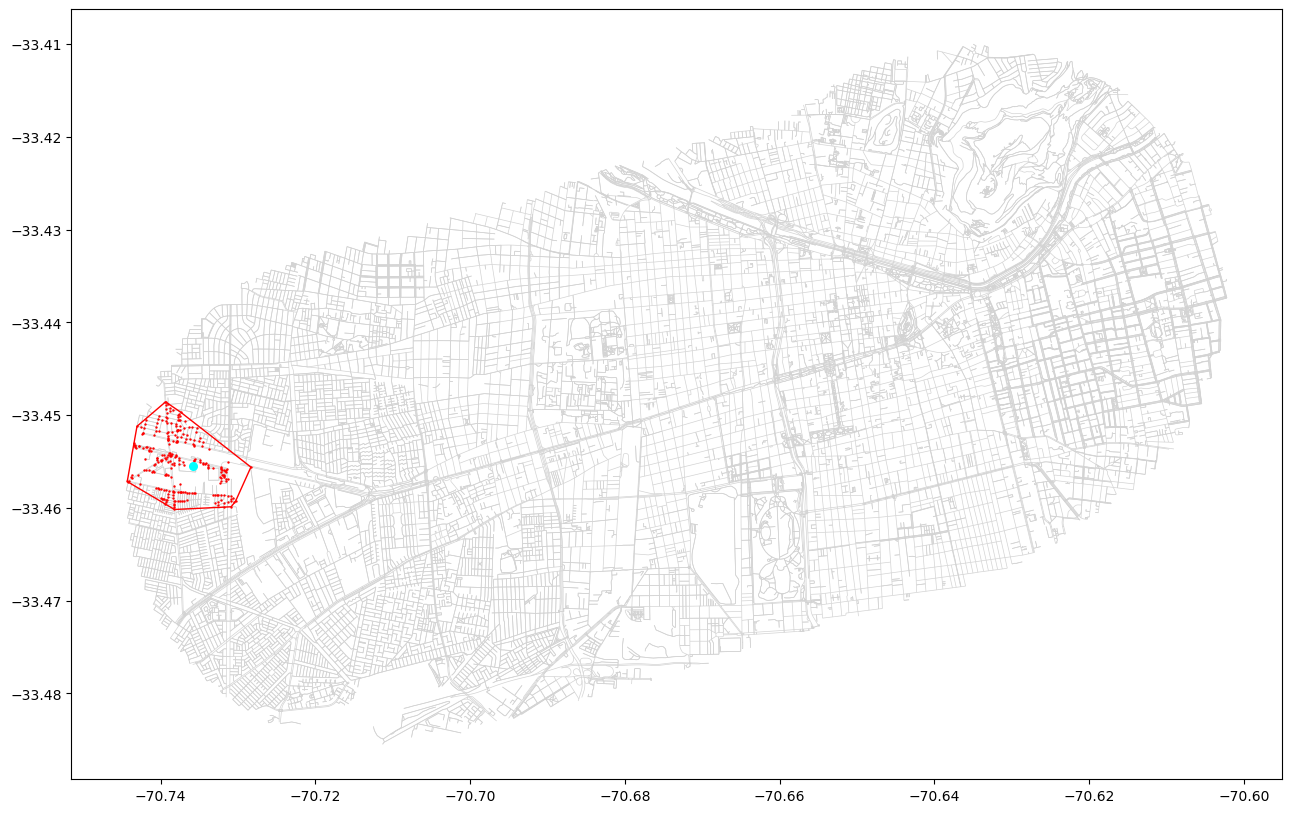

In [27]:
# Show plot
fig,ax = plt.subplots(figsize=(20,10))
nearest.plot(ax=ax,zorder=2,color='cyan',markersize=30)
isochrones_gdf.plot(ax=ax,zorder=2,facecolor='None',edgecolor='red')
nodes_at_15min.plot(ax=ax,c='red',markersize=0.5)
edges.plot(ax=ax,zorder=0,linewidth=0.5,edgecolor='lightgray')

#### __Attempt 3 - Success__ - Function creation

In [65]:
def calculate_proximity_isochrone(G, nodes, edges, center_node, poi_name, trip_time, 
                                  prox_measure='length', projected_crs="EPSG:6372"):

    # 1.0 --------------- PREPARE DATA
    count_pois = (True,trip_time)
    
    # Defines projection for downloaded data
    nodes = nodes.set_crs("EPSG:4326")
    edges = edges.set_crs("EPSG:4326")
    center_node = center_node.set_crs("EPSG:4326")

    # 2.0 --------------- ASSIGN CENTER NODE TO NEAREST OSMnx NODE
    # Find nearest osmnx node to center node
    nearest = aup.find_nearest(G, nodes, center_node, return_distance= True)
    nearest = nearest.set_crs("EPSG:4326")

    # 3.0 --------------- FORMAT NETWORK DATA
    # Fill NANs in length with calculated length (prevents crash)
    no_length = len(edges.loc[edges['length'].isna()])
    edges = edges.to_crs(projected_crs)
    edges['length'].fillna(edges.length,inplace=True)
    edges = edges.to_crs("EPSG:4326")
    print(f"Calculated length for {no_length} edges that had no length data.")

    # If prox_measure = 'length', calculates time_min assuming walking speed = 4km/hr
    if prox_measure == 'length':
        edges['time_min'] = (edges['length']*60)/4000
    else:
        # NaNs in time_min? --> Assume walking speed = 4km/hr
        no_time = len(edges.loc[edges['time_min'].isna()])
        edges['time_min'].fillna((edges['length']*60)/4000,inplace=True)
        print(f"Calculated time for {no_time} edges that had no time data.")

    # 4.0 --------------- PROCESS DISTANCE
    nodes_analysis = nodes.reset_index().copy()
    nodes_time = nodes.copy()

    # Calculate distances
    nodes_distance_prep = aup.calculate_distance_nearest_poi(nearest, nodes_analysis, edges, poi_name,'osmid', wght='time_min',count_pois=count_pois)

    # Extract from nodes_distance_prep the calculated time data
    nodes_time['time_'+poi_name] = nodes_distance_prep['dist_'+poi_name]

    # Extract from nodes_distance_prep the calculated pois count
    nodes_time[f'{poi_name}_{count_pois[1]}min'] = nodes_distance_prep[f'{poi_name}_{count_pois[1]}min']

    # Organice and filter output data
    nodes_time.reset_index(inplace=True)
    nodes_time = nodes_time.set_crs("EPSG:4326")
    nodes_time = nodes_time[['osmid','time_'+poi_name,f'{poi_name}_{count_pois[1]}min','x','y','geometry']]
    
    # 5.0 --------------- GET ISOCHRONE FOR CURRENT CENTER NODE    
    # Keep only nodes where nearest was found at an _x_ time distance
    nodes_at_15min = nodes_time.loc[nodes_time[f"{poi_name}_{count_pois[1]}min"]>0]
    
    # Create isochrone using convex hull to those nodes and add osmid from which this isochrone formed
    hull_geometry = nodes_at_15min.unary_union.convex_hull

    return hull_geometry

In [60]:
nearest_all = nodes.set_crs("EPSG:4326").reset_index()[['osmid','geometry']]
center_node = nearest_all.loc[nearest_all.osmid==11889994086]
center_node

,osmid,geometry
23445,11889994086,POINT (-70.73576 -33.45551)


Calculated length for 0 edges that had no length data.


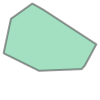

In [66]:
isochrones_gdf = gpd.GeoDataFrame()
hull_geom = calculate_proximity_isochrone(G, nodes, edges, center_node, poi_name='nodes', trip_time=15, prox_measure='length', projected_crs="EPSG:32719")
hull_geom

In [67]:
i = 0
isochrones_gdf.loc[i,'osmid'] = nearest.osmid.unique()[0]
isochrones_gdf.loc[i,'geometry'] = hull_geom

isochrones_gdf

,osmid,geometry
0,1.188999e+10,"POLYGON ((-70.73822 -33.46018, -70.74420 -33.4..."


<Axes: >

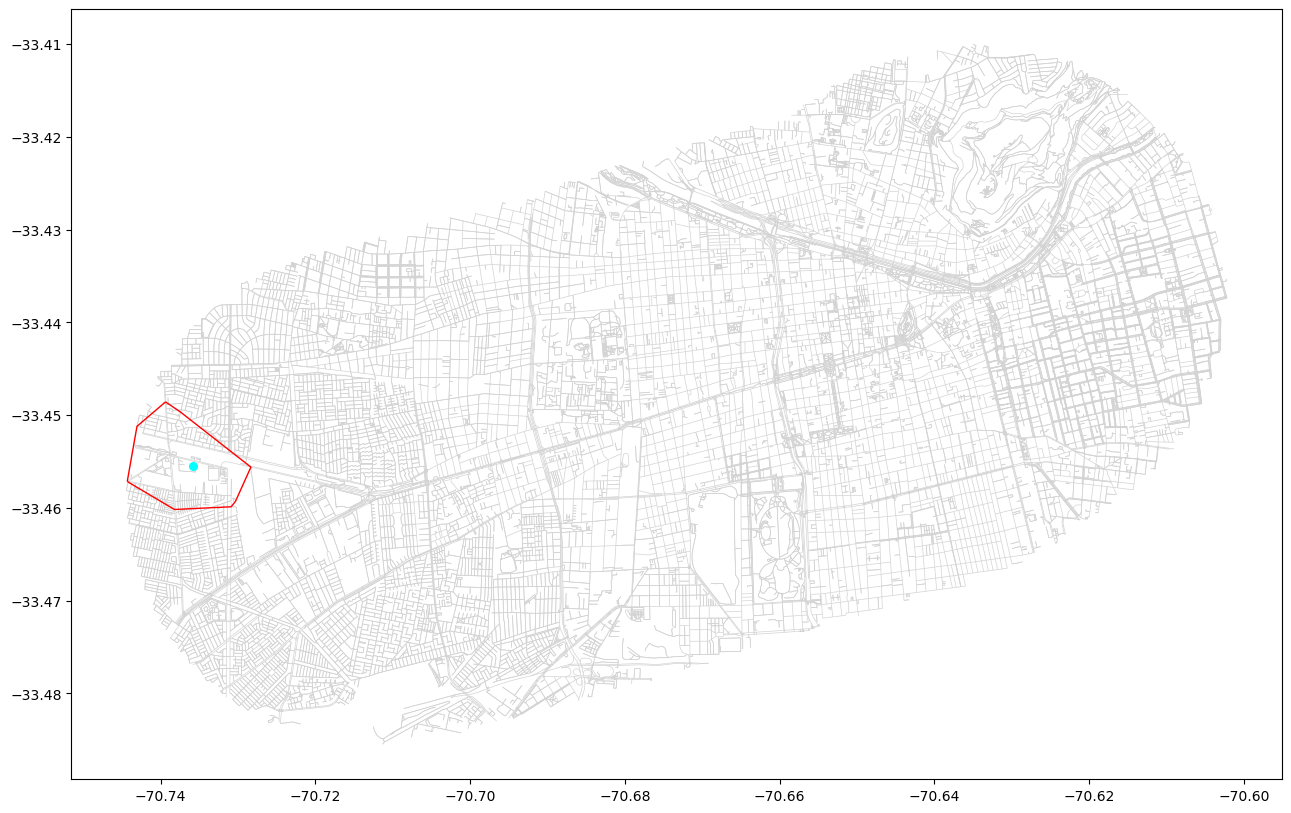

In [68]:
# Show plot
fig,ax = plt.subplots(figsize=(20,10))
center_node.plot(ax=ax,zorder=2,color='cyan',markersize=30)
isochrones_gdf.plot(ax=ax,zorder=2,facecolor='None',edgecolor='red')
edges.plot(ax=ax,zorder=0,linewidth=0.5,edgecolor='lightgray')

## Function test
#### Once finished developing __function analysis.py/proximity_isochrone()__, tested on various pois:

In [19]:
pois = nodes.reset_index().copy()[['osmid','geometry']]

isochrones_gdf = gpd.GeoDataFrame()
i = 0

osmid_list = list(pois.osmid.unique())[0:50]
k = len(osmid_list)

for osmid in osmid_list:

    # Current node being analysed
    point_of_interest = pois.loc[pois.osmid == osmid].copy()
    
    # Calculate isochrone geometry
    hull_geom = aup.proximity_isochrone(G, nodes, edges, point_of_interest, 
                                        trip_time=15, prox_measure="length", projected_crs="EPSG:6372")

    # Assign osmid and geometry to created isochrone and save to gdf
    isochrones_gdf.loc[i,'osmid'] = point_of_interest.osmid.unique()[0]
    isochrones_gdf.loc[i,'geometry'] = hull_geom

    print(f"Progress: {i}/{k}")
    i += 1

# Show
print(isochrones_gdf.shape)
isochrones_gdf.head(1)

Progress: 0/50
Progress: 1/50
Progress: 2/50
Progress: 3/50
Progress: 4/50
Progress: 5/50
Progress: 6/50
Progress: 7/50
Progress: 8/50
Progress: 9/50
Progress: 10/50
Progress: 11/50
Progress: 12/50
Progress: 13/50
Progress: 14/50
Progress: 15/50
Progress: 16/50
Progress: 17/50
Progress: 18/50
Progress: 19/50
Progress: 20/50
Progress: 21/50
Progress: 22/50
Progress: 23/50
Progress: 24/50
Progress: 25/50
Progress: 26/50
Progress: 27/50
Progress: 28/50
Progress: 29/50
Progress: 30/50
Progress: 31/50
Progress: 32/50
Progress: 33/50
Progress: 34/50
Progress: 35/50
Progress: 36/50
Progress: 37/50
Progress: 38/50
Progress: 39/50
Progress: 40/50
Progress: 41/50
Progress: 42/50
Progress: 43/50
Progress: 44/50
Progress: 45/50
Progress: 46/50
Progress: 47/50
Progress: 48/50
Progress: 49/50
(50, 2)


,osmid,geometry
0,386138.0,"POLYGON ((-70.64681 -33.45128, -70.65617 -33.4..."


<Axes: >

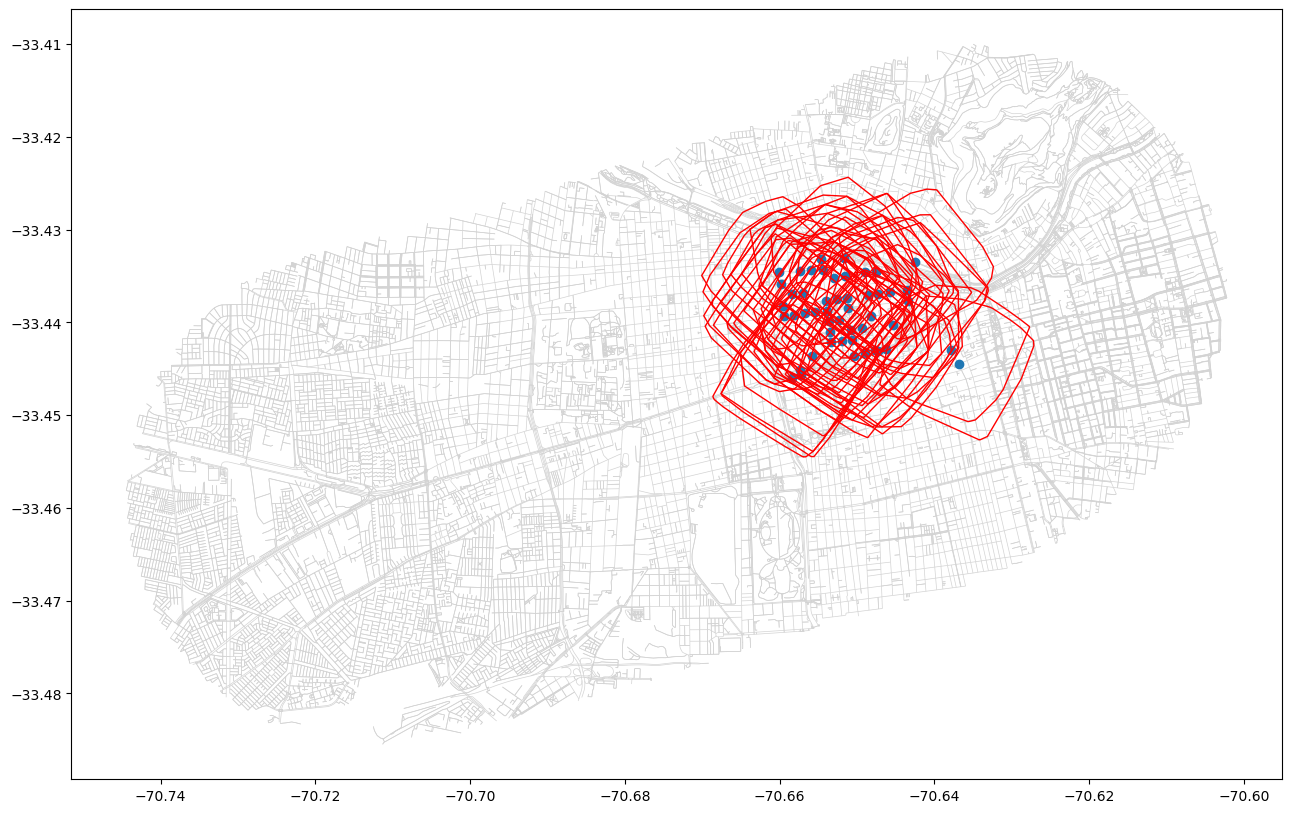

In [23]:
test_nodes = pois.loc[pois.osmid.isin(osmid_list)].copy()

# Show plot
fig,ax = plt.subplots(figsize=(20,10))
test_nodes.plot(ax=ax)
isochrones_gdf.plot(ax=ax,facecolor='None',edgecolor='red',linewidth=1)
edges.plot(ax=ax,zorder=0,linewidth=0.5,edgecolor='lightgray')